## Предикт LTV користувача

**Задача:** розрахувати фактичний LTV та побудувати предикт на рік на основі тижневих когорт.

Загальний план: побудувати retention curve, підібрати модель для екстраполяції, і на її основі спрогнозувати кумулятивний LTV на 52 тижні.

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('KMA TestTask Product Analyst - Task2.csv')

print("Dataset shape:", df.shape)
print(f"\nUsers: {df['user_id'].nunique()}")
print(f"Cohorts: {df['cohort_week'].nunique()}")
print(f"Product IDs: {df['product_id'].unique()}")
print(f"\nMissing values:")
print(df.isnull().sum())

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['first_purchase_time'] = pd.to_datetime(df['first_purchase_time'])
df['cohort_week'] = pd.to_datetime(df['cohort_week'])

print(f"\nDate range: {df['event_timestamp'].min().date()} - {df['event_timestamp'].max().date()}")
print(f"Cohort range: {df['cohort_week'].min().date()} — {df['cohort_week'].max().date()}")

ppu = df.groupby('user_id').size()
print(f"\nPurchases per user: mean={ppu.mean():.1f}, median={ppu.median():.0f}, max={ppu.max()}")

Dataset shape: (6086, 6)

Users: 934
Cohorts: 32
Product IDs: ['weekly.2.49']

Missing values:
user_id                0
event_timestamp        0
first_purchase_time    0
cohort_week            0
lifetime_weeks         0
product_id             0
dtype: int64

Date range: 2023-03-02 - 2023-10-17
Cohort range: 2023-02-26 — 2023-10-08

Purchases per user: mean=6.5, median=3, max=32


In [4]:
cohort_sizes = df.groupby('cohort_week')['user_id'].nunique().sort_index()
print("Users per cohort:")
print(cohort_sizes.to_string())
print(f"\nCohorts with >= 10 users: {(cohort_sizes >= 10).sum()}")
print(f"Cohorts with < 10 users: {(cohort_sizes < 10).sum()}")

Users per cohort:
cohort_week
2023-02-26    20
2023-03-05    88
2023-03-12    69
2023-03-19    84
2023-03-26    50
2023-04-02    36
2023-04-09    43
2023-04-16    56
2023-04-23    67
2023-04-30    68
2023-05-07    66
2023-05-14    81
2023-05-21    55
2023-05-28    32
2023-06-04    40
2023-06-11    12
2023-06-18    12
2023-06-25     8
2023-07-02    10
2023-07-09     2
2023-07-16     3
2023-07-23     4
2023-07-30     2
2023-08-06     1
2023-08-13     4
2023-08-20     6
2023-08-27     4
2023-09-03     2
2023-09-10     2
2023-09-17     3
2023-09-24     3
2023-10-08     1

Cohorts with >= 10 users: 18
Cohorts with < 10 users: 14


Всі 934 користувачі на одній підписці weekly.2.49 ($2.49/тиждень). Кожний рядок це renewal.

Когорти лютий-червень мають 10-88 користувачів, липень-жовтень — 1-6 користувачів. При побудові передбачення доцільніше буде брати до уваги когорти, де є 10+ користувачів задля уникнення шуму.

In [13]:
# Retention по всіх когортах
retention_all = df.groupby(['cohort_week', 'lifetime_weeks'])['user_id'].nunique().reset_index()
retention_all.columns = ['cohort_week', 'lifetime_weeks', 'users']

PRICE = 2.49

w0_all = retention_all[retention_all['lifetime_weeks'] == 0].set_index('cohort_week')['users']
retention_all = retention_all.merge(w0_all.rename('cohort_size'), left_on='cohort_week', right_index=True)
retention_all['retention'] = retention_all['users'] / retention_all['cohort_size']

avg_all = retention_all.groupby('lifetime_weeks').agg(
    retention=('retention', 'mean'),
    n_cohorts=('cohort_week', 'nunique')
).reset_index()

ret_all = avg_all['retention'].values
cumltv_all = np.cumsum(ret_all) * PRICE

print(f"{'Week':<6} {'Retention':>10} {'Cum LTV':>10} {'Cohorts':>10}")
for _, row in avg_all.iterrows():
    w = int(row['lifetime_weeks'])
    print(f"{w:<6} {row['retention']:>9.1%} {cumltv_all[w]:>9.2f}$ {int(row['n_cohorts']):>10}")

Week    Retention    Cum LTV    Cohorts
0         100.0%      2.49$         32
1          57.6%      3.92$         28
2          48.2%      5.12$         28
3          41.0%      6.14$         25
4          39.2%      7.12$         26
5          33.9%      7.96$         24
6          30.4%      8.72$         23
7          28.4%      9.43$         21
8          26.2%     10.08$         21
9          25.3%     10.71$         21
10         23.1%     11.29$         20
11         19.9%     11.78$         19
12         19.5%     12.27$         19
13         20.0%     12.77$         20
14         17.4%     13.20$         19
15         16.4%     13.61$         18
16         15.3%     13.99$         17
17         14.6%     14.35$         16
18         14.0%     14.70$         16
19         12.0%     15.00$         15
20         12.2%     15.31$         13
21         10.8%     15.57$         13
22          9.5%     15.81$         12
23          9.7%     16.05$         10
24          9.3%     16.

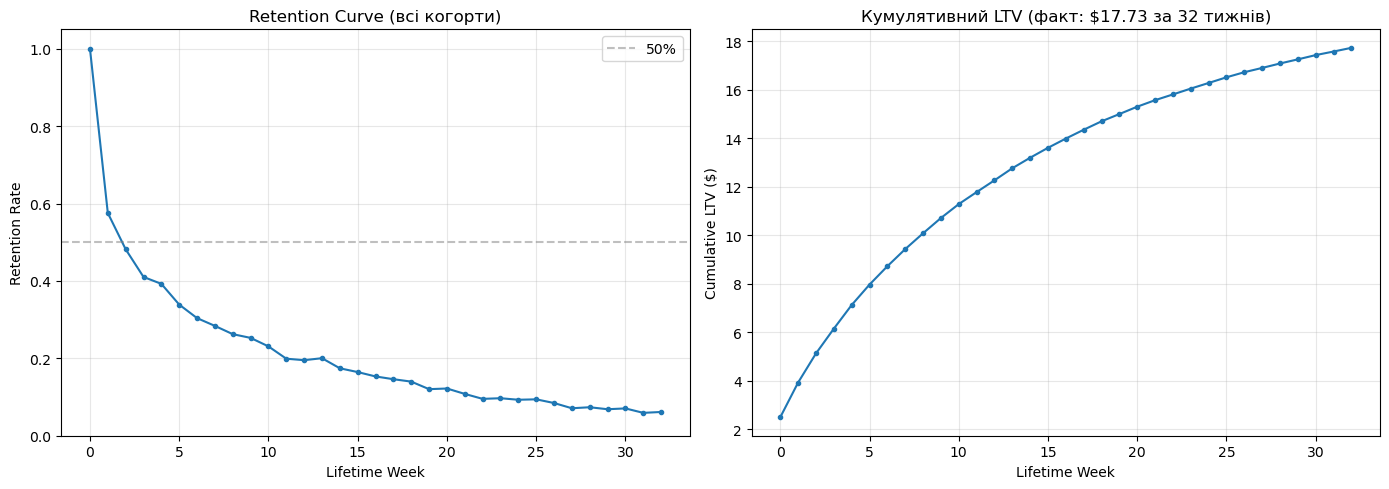

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

weeks_all = avg_all['lifetime_weeks'].values

ax1.plot(weeks_all, ret_all, 'o-', markersize=3)
ax1.set_xlabel('Lifetime Week')
ax1.set_ylabel('Retention Rate')
ax1.set_title('Retention Curve (всі когорти)')
ax1.set_ylim(0, 1.05)
ax1.grid(alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50%')
ax1.legend()

ax2.plot(weeks_all, cumltv_all, 'o-', markersize=3)
ax2.set_xlabel('Lifetime Week')
ax2.set_ylabel('Cumulative LTV ($)')
ax2.set_title(f'Кумулятивний LTV (факт: ${cumltv_all[-1]:.2f} за {len(ret_all)-1} тижнів)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Retention падає з 100% до 58% після першого тижня, потім поступово знижується. До тижня 32 залишається ~6% користувачів. 
Фактичний LTV за 32 тижні - $17.73. Крива ще не вийшла на плато — retention ~6% означає що частина юзерів продовжує платити і LTV повільно росте.

## Модель предикту

Для екстраполяції retention використовую power law: `retention(t) = a × (t + 1)^b`

Тут підписка тижнева, churn швидкий на початку і потім сповільнюється, це типова поведінка для subscription-продуктів, яку power law описує добре. Це достатньо проста і інтерпретована модель, яка ніколи не досягає 0, що реалістично, бо завжди є ядро лояльних користувачів.

Альтернативою можна взяти логарифмічну функцію, але вона опускається нижче нуля при великих t, що для retention не має сенсу.

In [8]:
#Фільтруємо дані з когортами понад 10 користувачів

mature_cohorts = cohort_sizes[cohort_sizes >= 10].index
df_mature = df[df['cohort_week'].isin(mature_cohorts)].copy()

ret_raw = df_mature.groupby(['cohort_week', 'lifetime_weeks'])['user_id'].nunique().reset_index()
ret_raw.columns = ['cohort_week', 'lifetime_weeks', 'users']
w0 = ret_raw[ret_raw['lifetime_weeks'] == 0].set_index('cohort_week')['users']
ret_raw = ret_raw.merge(w0.rename('cohort_size'), left_on='cohort_week', right_index=True)
ret_raw['retention'] = ret_raw['users'] / ret_raw['cohort_size']

avg_ret_clean = ret_raw.groupby('lifetime_weeks')['retention'].mean().values

def power_law(t, a, b):
    return a * np.power(t + 1, b)

t_actual = np.arange(len(avg_ret_clean))
popt, _ = curve_fit(power_law, t_actual, avg_ret_clean, p0=[1.0, -0.5])

a, b = popt
pred_retention = power_law(t_actual, *popt)
r2 = r2_score(avg_ret_clean, pred_retention)
mae = mean_absolute_error(avg_ret_clean, pred_retention)

print(f"Модель: retention(t) = {a:.4f} × (t + 1)^({b:.4f})")
print(f"\nЯкість на фактичних даних:")
print(f"  R²   = {r2:.4f}")
print(f"  MAE  = {mae:.4f}")

Модель: retention(t) = 1.0031 × (t + 1)^(-0.6757)

Якість на фактичних даних:
  R²   = 0.9839
  MAE  = 0.0202


Cross-validation (train: weeks 0-15, test: weeks 16-32)

  Train R²: 0.9927
  Test MAE: 0.0339

  LTV at week 32:
    Actual:    $17.47
    Predicted: $18.88
    Error:     8.1%


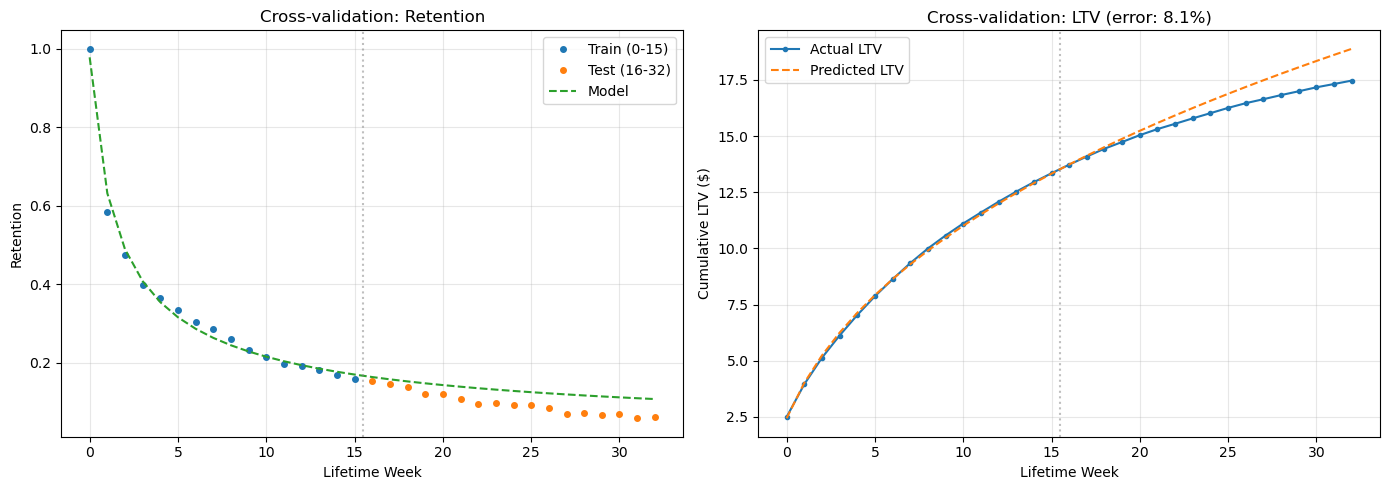

In [10]:
# Cross-validation: train на тижнях 0-15, test на 16-32
train_weeks = 16
t_train = np.arange(train_weeks)
r_train = avg_ret_clean[:train_weeks]

t_test = np.arange(train_weeks, len(avg_ret_clean))
r_test = avg_ret_clean[train_weeks:]

popt_cv, _ = curve_fit(power_law, t_train, r_train, p0=[1.0, -0.5])

pred_test = power_law(t_test, *popt_cv)
ltv_actual = np.cumsum(avg_ret_clean) * PRICE
ltv_pred_cv = np.cumsum(power_law(np.arange(len(avg_ret_clean)), *popt_cv)) * PRICE

cv_error = abs(ltv_pred_cv[-1] - ltv_actual[-1]) / ltv_actual[-1] * 100

print(f"Cross-validation (train: weeks 0-15, test: weeks 16-32)")
print(f"\n  Train R²: {r2_score(r_train, power_law(t_train, *popt_cv)):.4f}")
print(f"  Test MAE: {mean_absolute_error(r_test, pred_test):.4f}")
print(f"\n  LTV at week 32:")
print(f"    Actual:    ${ltv_actual[-1]:.2f}")
print(f"    Predicted: ${ltv_pred_cv[-1]:.2f}")
print(f"    Error:     {cv_error:.1f}%")

# Графік cross-validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t_train, r_train, 'o', markersize=4, label='Train (0-15)')
ax1.plot(t_test, r_test, 'o', markersize=4, label='Test (16-32)')
ax1.plot(np.arange(len(avg_ret_clean)), power_law(np.arange(len(avg_ret_clean)), *popt_cv),
         '--', label='Model')
ax1.axvline(x=15.5, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Lifetime Week')
ax1.set_ylabel('Retention')
ax1.set_title('Cross-validation: Retention')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(np.arange(len(avg_ret_clean)), ltv_actual, 'o-', markersize=3, label='Actual LTV')
ax2.plot(np.arange(len(avg_ret_clean)), ltv_pred_cv, '--', label='Predicted LTV')
ax2.axvline(x=15.5, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Lifetime Week')
ax2.set_ylabel('Cumulative LTV ($)')
ax2.set_title(f'Cross-validation: LTV (error: {cv_error:.1f}%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Модель навчена на тижнях 0-15, перевірена на 16-32. Похибка кумулятивного LTV — ~8%.

Retention на тестових тижнях модель трохи переоцінює, що дає завищення LTV.

In [16]:
# Предикт на 52 тижні (1 рік)
t_pred = np.arange(53)
ret_pred = power_law(t_pred, *popt)
cumltv_pred = np.cumsum(ret_pred) * PRICE

print(f"Predicted annual LTV: ${cumltv_pred[-1]:.2f}")
print(f"Predicted retention at week 52: {ret_pred[-1]:.1%}\n")

milestones = [4, 8, 12, 16, 20, 24, 32, 40, 48, 52]
rows = []
for w in milestones:
    row = {'Week': w, 'Pred Retention': f"{ret_pred[w]:.1%}", 'Pred LTV': f"${cumltv_pred[w]:.2f}"}
    if w < len(ret_all):
        row['Fact Retention'] = f"{ret_all[w]:.1%}"
        row['Fact LTV'] = f"${cumltv_all[w]:.2f}"
    else:
        row['Fact Retention'] = '—'
        row['Fact LTV'] = '—'
    rows.append(row)

pd.DataFrame(rows)[['Week', 'Fact Retention', 'Fact LTV', 'Pred Retention', 'Pred LTV']]

Predicted annual LTV: $21.68
Predicted retention at week 52: 6.9%



,Week,Fact Retention,Fact LTV,Pred Retention,Pred LTV
0,4,39.2%,$7.12,33.8%,$7.07
1,8,26.2%,$10.08,22.7%,$9.67
2,12,19.5%,$12.27,17.7%,$11.59
3,16,15.3%,$13.99,14.8%,$13.17
4,20,12.2%,$15.31,12.8%,$14.51
5,24,9.3%,$16.28,11.4%,$15.70
6,32,6.1%,$17.73,9.4%,$17.73
7,40,—,—,8.2%,$19.46
8,48,—,—,7.2%,$20.98
9,52,—,—,6.9%,$21.68


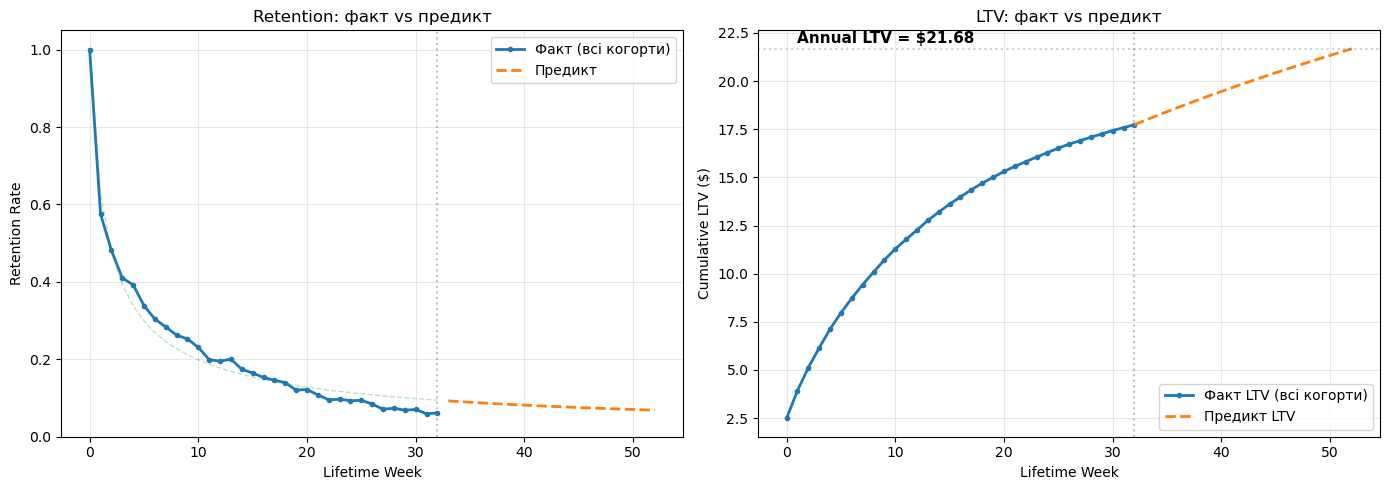

In [17]:
max_actual = len(ret_all)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Retention: факт (всі когорти) vs предикт
ax1.plot(np.arange(max_actual), ret_all, 'o-', markersize=3, label='Факт (всі когорти)', linewidth=2)
ax1.plot(t_pred[max_actual:], ret_pred[max_actual:], '--', label='Предикт', linewidth=2)
ax1.plot(t_pred[:max_actual], ret_pred[:max_actual], '--', alpha=0.3, linewidth=1)
ax1.axvline(x=max_actual - 1, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Lifetime Week')
ax1.set_ylabel('Retention Rate')
ax1.set_title('Retention: факт vs предикт')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 1.05)

# LTV: факт (всі когорти) vs предикт
ax2.plot(np.arange(max_actual), cumltv_all, 'o-', markersize=3, label='Факт LTV (всі когорти)', linewidth=2)
ax2.plot(t_pred[max_actual-1:], cumltv_pred[max_actual-1:], '--', label='Предикт LTV', linewidth=2)
ax2.axvline(x=max_actual - 1, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(y=cumltv_pred[-1], linestyle=':', alpha=0.3)
ax2.text(1, cumltv_pred[-1] + 0.3, f'Annual LTV = ${cumltv_pred[-1]:.2f}', fontsize=11, fontweight='bold')
ax2.set_xlabel('Lifetime Week')
ax2.set_ylabel('Cumulative LTV ($)')
ax2.set_title('LTV: факт vs предикт')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Оцінка якості моделі
print(f"\nFit на чистих даних (когорти >=10):")
print(f"   R²   = {r2:.4f}")
print(f"   MAE  = {mae:.4f}")

print(f"\nCross-validation (train 0-15, test 16-32):")
print(f"   LTV error at week 32: {cv_error:.1f}%")

print(f"\nPredicted Annual LTV: ${cumltv_pred[-1]:.2f}")
ltv_low = cumltv_pred[-1] * (1 - cv_error / 100)
ltv_high = cumltv_pred[-1] * (1 + cv_error / 100)
print(f"   Approximate range: ${ltv_low:.2f} — ${ltv_high:.2f}")


Fit на чистих даних (когорти >=10):
   R²   = 0.9839
   MAE  = 0.0202

Cross-validation (train 0-15, test 16-32):
   LTV error at week 32: 8.1%

Predicted Annual LTV: $21.68
   Approximate range: $19.92 — $23.43


## Висновок

Річний LTV — приблизно $21-22, з похибкою порядку 8% на cross-validation. Модель трохи завищує retention на пізніх тижнях, тому реальне значення скоріше ближче до нижньої межі. На тижні 52 retention прогнозується ~7% — невелике, але ненульове ядро лояльних юзерів.

Щодо покращення предикту: з одною підпискою і 934 юзерами power law дає прийнятну точність, але якщо потрібна більша впевненість — варто спробувати BG/NBD, подивитися чи поведінка різних когорт відрізняється, або просто зібрати більше даних для довшого спостереження. 